In [2]:
import sys
sys.path.append('C:/Users/Billy/Documents/PRISMO/Backtester')
from multiprocessing import Process
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time
import random
from mathCode.johansenMain import coint_johansen
from tqdm import tqdm_notebook
from IPython.display import clear_output
import itertools
import datetime
import os
from base_model_backtest import backtest
import random
from pandas_datareader import data as pdr
import logging
from pandas.plotting import register_matplotlib_converters
from functionSource import *
from operator import itemgetter


register_matplotlib_converters()
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
plt.style.use(['ggplot'])

In [43]:
def APR(returns):
    ave = []
    for year in range(returns.index[0].year, returns.index[-1].year+1):
        annualReturns = returns.loc[returns.index<str(year+1)+'-01-01']
        annualReturns = annualReturns.loc[annualReturns.index>=str(year)+'-01-01']

        aveReturns = np.mean(annualReturns) 
        ave.append(aveReturns*252*100)
        

    return np.mean(ave)

def optimize(toTrade, delta_in = None, ve_in = None, plot = None):
    asset = toTrade[-1]
    toTrade = toTrade[:-1]
    
    
    if asset == 'asx_oc':
        data = pickle.load(open('D:/PRISMO/historicalData/data/asx200nobiasFINAL.pickle','rb'))
        data_open = data.loc[(slice(None), toTrade)].xs('OPEN',axis=1,level=1).dropna()
        data_open.index = data_open.index+pd.Timedelta(10,'H')
        data_close = data.loc[(slice(None), toTrade)].xs('CLOSE',axis=1,level=1).dropna()
        data_close.index = data_open.index+pd.Timedelta(16,'H')
        openAndClose = pd.concat([data_open,data_close]).sort_index()
        openAndClose['OPEN'] =False
        openAndClose['CLOSE'] =False
        openAndClose.loc[openAndClose.index.hour==16,'CLOSE']=True
        openAndClose.loc[openAndClose.index.hour==10,'OPEN']=True
        
    if asset == 'asx':
        data = pickle.load(open('D:/PRISMO/historicalData/data/asx200nobiasFINAL.pickle','rb'))
        data_open = data.loc[(slice(None), toTrade)].xs('OPEN',axis=1,level=1).dropna()
        data_open.index = data_open.index+pd.Timedelta(10,'H')
        data_close = data.loc[(slice(None), toTrade)].xs('CLOSE',axis=1,level=1).dropna()
        data_close.index = data_open.index+pd.Timedelta(16,'H')
        openAndClose=data_close
        
    results=[]
    results.append(['delta','ve','cumret','sharpe','weightedCum','weightedSharpe'])
    ve_values = []
    delta_values = []
    for ve_ in range(1,10):
        order = round(0.1**(ve_+2), 12)
        for i in range(1,10):
            ve_values.append(round(i*order,12))
            delta_values.append(round(i*order,12))
            
            
    if delta_in is not None:
        delta_values = delta_in
    
    if ve_in is not None:
        ve_values = ve_in
        
    for delta in delta_values:
        for Ve in ve_values:
            close = openAndClose
            #INIT
            yhatList = []
            QList= []
            eList=[]
            betaList = [np.matrix([[0],[0]])]
            R = np.zeros([len(toTrade),len(toTrade)])
            P = np.zeros([len(toTrade),len(toTrade)])
            y = []
            hedges = []
            Vw = delta/(1-delta)*np.diag(np.ones(len(toTrade)))

            for row in openAndClose.iterrows():
               
                #Extract x and y from the row, put them into numpy form. We include a constant for x so we can fit with a constant.
                x = np.matrix([[row[1][toTrade[0]]],[1]])
                y = np.matrix(row[1][toTrade[1]])
                ## 1 STEP AHEAD PREDICTION ##
                beta = betaList[-1]                                            # beta(t|t-1) = beta(t-1|t-1)
                R = P +Vw                                       #    R(t|t-1) = R(t-1|t-1) + Vw
                yhat = np.dot(x.T, beta)                                        #        yhat = x.beta
                e_t = y - yhat                                                  #        e(t) = y(t) - yhat(t)
                Q_t = np.dot( np.dot(x.T, R) , x ) +Ve               #        Q(t) = var(e(t)) = var(y(t) - yhat(t)) 
                #                                                                             = var(y(t)) + var(yhat(t)) + cov[y(t), yhat(t)]
                #                                                                             = x . R(t|t-1) + Ve


                ## UPDATE PARAMETERS ##
                K = np.dot(R, x) / Q_t                                                 # K is the kalman gain
                beta = beta + K*e_t                                                         # beta(t|t) = beta(t|t-1)+K(t)e(t)
                P = R - np.dot( np.dot(K, np.transpose(x)), R)               # We denote R(t|t) by P, and R(t|t-1) as R. R(t | t − 1) = cov(β(t) − βhat(t|t-1))

                #Add beta and predicted y values to arrays for storage
                betaList.append(beta)
                yhatList.append(yhat)

                #Form the hedge ratio as a float
                hedgeRatio = beta[0].tolist()[0][0]
                hedges.append(hedgeRatio)
                eList.append(e_t.tolist()[0][0])
                QList.append(Q_t.tolist()[0][0])
            
        
            
            close.loc[slice(None),'e'] = eList
            close.loc[slice(None),'Q'] = QList
            plt.plot(eList)
            plt.plot(np.sqrt(QList))
            plt.plot(-np.sqrt(QList))

            plt.show()
            time.sleep(5)
            if np.mean(close['e'])>np.sqrt(np.mean(close['Q'])):
#                 print('means',np.mean(close['e']), np.sqrt(np.mean(close['Q'])))
    #             if the average error is greater than the average deviation the parameters are fucked. No point going further
                break

            
            close.loc[slice(None),'LongEntry'] = close['e']<-np.sqrt(close['Q'])
            close.loc[slice(None),'LongExit'] = close['e']>-np.sqrt(close['Q'])
            close.loc[slice(None),'ShortEntry'] = close['e']>np.sqrt(close['Q'])
            close.loc[slice(None),'ShortExit'] = close['e']<np.sqrt(close['Q'])
            ratios = hedges
            numUnitsLong = np.array([[np.nan]]*len(close))
            numUnitsShort = np.array([[np.nan]]*len(close))

            numUnitsLong[0] = 1
            numUnitsLong[np.array(close['LongEntry'])] = 1
            numUnitsLong[np.array(close['LongExit'])] = 0
            
            numUnitsShort[0] = 1
            numUnitsShort[np.array(close['ShortEntry'])] = -1
            numUnitsShort[np.array(close['ShortExit'])] = 0

            close.loc[slice(None),'short'] = numUnitsShort
            close.loc[slice(None),'short'].fillna('ffill')
            close.loc[slice(None),'long'] =  numUnitsLong
            close.loc[slice(None),'long'].fillna('ffill')
            print(close[['short','long']])
            close.loc[slice(None),'numUnits'] = close['long'] + close['short']

            close.loc[slice(None),'numUnits'+toTrade[0]] = -close['numUnits']*ratios
            close.loc[slice(None),'numUnits'+toTrade[1]] = close['numUnits']

            close.loc[slice(None),'positions'+toTrade[0]] = close['numUnits'+toTrade[0]]*close[toTrade[0]]
            close.loc[slice(None),'positions'+toTrade[1]] = close['numUnits'+toTrade[1]]*close[toTrade[1]]
            
            comission = (close['positions'+toTrade[0]].shift(1)+close['positions'+toTrade[1]].shift(1))*0.0008
#             comission = 0
            close.loc[slice(None),'pnl'] = close[toTrade[0]].pct_change()*(close['positions'+toTrade[0]].shift(1)) + close[toTrade[1]].pct_change()*(close['positions'+toTrade[1]].shift(1))-comission
            
           
            
            
            close.loc[slice(None),'returns'] = (close['pnl'])/(np.abs(close['positions'+toTrade[0]]) +np.abs(close['positions'+toTrade[0]])).shift(1)

#             close.loc[slice(None),'returns']= close['returns'][close['returns']<0.1]
            
            sharpe = (np.mean(close['returns']))
            try:
                numTrades = len(close[close['numUnits']!=0])/2
#                 print('Number of Trades: ',numTrades)
                if numTrades > 50:
    #                 monotonicity = monotonicityMeasure(np.cumsum(close['returns'].fillna(0)))
                    monotonicity = 1
                    weightedSharpe = monotonicity*sharpe
                    weightedRet = monotonicity*np.cumsum(close['returns'].fillna(0)).iloc[-1]
                    if plot == True:
    #                         %matplotlib notebook

                        plt.plot(np.cumsum(close['returns'].fillna(0)))
                        plt.show()
                    print([delta, Ve,np.cumsum(close['returns'].fillna(0)).iloc[-1], sharpe, weightedRet, weightedSharpe])
                    results.append([delta, Ve,np.cumsum(close['returns'].fillna(0)).iloc[-1], sharpe, weightedRet, weightedSharpe])

            except Exception as e:
                print(e)
    pickle.dump(results, open('C:/Users/Billy/Documents/PRISMO/Backtester/optimizers/cointegration/results/'+flatten(toTrade)+'.pickle','wb'))
    

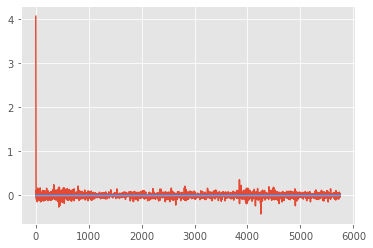

                     short  long
Date                            
2007-11-29 10:00:00   -1.0   0.0
2007-11-30 02:00:00   -1.0   0.0
2007-11-30 10:00:00   -1.0   0.0
2007-12-01 02:00:00   -1.0   0.0
2007-12-03 10:00:00   -1.0   0.0
2007-12-04 02:00:00   -1.0   0.0
2007-12-04 10:00:00   -1.0   0.0
2007-12-05 02:00:00   -1.0   0.0
2007-12-05 10:00:00   -1.0   0.0
2007-12-06 02:00:00    0.0   1.0
2007-12-06 10:00:00   -1.0   0.0
2007-12-07 02:00:00    0.0   1.0
2007-12-07 10:00:00    0.0   1.0
2007-12-08 02:00:00   -1.0   0.0
2007-12-10 10:00:00   -1.0   0.0
2007-12-11 02:00:00    0.0   0.0
2007-12-11 10:00:00    0.0   1.0
2007-12-12 02:00:00    0.0   0.0
2007-12-12 10:00:00    0.0   1.0
2007-12-13 02:00:00    0.0   1.0
2007-12-13 10:00:00    0.0   1.0
2007-12-14 02:00:00    0.0   1.0
2007-12-14 10:00:00    0.0   1.0
2007-12-15 02:00:00    0.0   1.0
2007-12-17 10:00:00    0.0   0.0
2007-12-18 02:00:00   -1.0   0.0
2007-12-18 10:00:00   -1.0   0.0
2007-12-19 02:00:00    0.0   1.0
2007-12-19

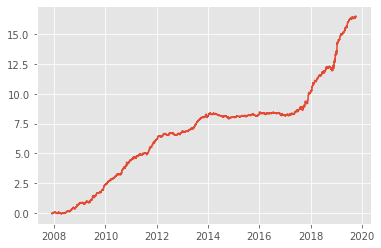

[4e-07, 2e-05, 16.43711535961563, 0.0032867657187793655, 16.43711535961563, 0.0032867657187793655]


In [44]:
optimize(['TLS.AX','SKC.AX','asx_oc'],[4e-07],[2e-05],True)

In [25]:
data = pickle.load(open('D:/PRISMO/historicalData/data/asx200nobiasFINAL.pickle','rb'))

In [26]:
data.loc[(slice(None),['TLS.AX','SKC.AX'])]

TLS.AX                                         SKC.AX              \
             HIGH CLOSE    LOW  OPEN    COUNT      VOLUME   HIGH CLOSE   LOW   
Date                                                                           
1990-01-02    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-03    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-04    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-05    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-08    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-09    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-10    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-11    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-12    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-15    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-16    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-17    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-18    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-19    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-22    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-23    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-24    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-25    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-26    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-30    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-01-31    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-02-01    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-02-02    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-02-05    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-02-06    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-02-07    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-02-08    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-02-09    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-02-12    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
1990-02-13    NaN   NaN    NaN   NaN      NaN         NaN    NaN   NaN   NaN   
...           ...   ...    ...   ...      ...         ...    ...   ...   ...   
2019-08-28  3.685  3.68  3.630  3.66   6930.0  31555700.0  3.710  3.71  3.67   
2019-08-29  3.670  3.66  3.610  3.66   6861.0  36358021.0  3.620  3.58  3.58   
2019-08-30  3.720  3.72  3.640  3.67   6195.0  29369535.0  3.620  3.60  3.59   
2019-09-02  3.690  3.64  3.620  3.65   5409.0  15391385.0  3.620  3.61  3.59   
2019-09-03  3.630  3.61  3.600  3.60   4978.0  16623838.0  3.620  3.59  3.59   
2019-09-04  3.590  3.57  3.555  3.57   6726.0  40237788.0  3.620  3.62  3.57   
2019-09-05  3.630  3.59  3.560  3.58   6701.0  33295633.0  3.670  3.65  3.61   
2019-09-06  3.640  3.61  3.570  3.60   5324.0  24949855.0  3.700  3.68  3.66   
2019-09-09  3.620  3.60  3.580  3.59   6353.0  16598660.0  3.750  3.74  3.68   
2019-09-10  3.590  3.56  3.510  3.58  10445.0  52318872.0  3.760  3.75  3.71   
2019-09-11  3.580  3.56  3.530  3.58   7178.0  31157291.0  3.750  3.75  3.72   
2019-09-12  3.630  3.59  3.565  3.59   7100.0  42733429.0  3.810  3.81  3.74   
2019-09-13  3.620  3.61  3.590  3.60   5671.0  25435549.0  3.850  3.82  3.78   
2019-09-16  3.590  3.57  3.540  3.57   6101.0  40596579.0  3.800  3.78  3.74   
2019-09-17  3.580  3.57  3.520  3.56   6785.0  29849207.0  3.780  3.71  3.71   
2019-09-18  3.600  3.55  3.550  3.56   6185.0  36298238.0  3.750  3.65  3.65   
2019-09-19 

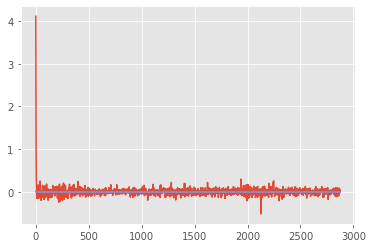

                     short  long
Date                            
2007-11-30 02:00:00   -1.0   0.0
2007-12-01 02:00:00   -1.0   0.0
2007-12-04 02:00:00   -1.0   0.0
2007-12-05 02:00:00   -1.0   0.0
2007-12-06 02:00:00   -1.0   0.0
2007-12-07 02:00:00   -1.0   0.0
2007-12-08 02:00:00   -1.0   0.0
2007-12-11 02:00:00   -1.0   0.0
2007-12-12 02:00:00    0.0   0.0
2007-12-13 02:00:00    0.0   1.0
2007-12-14 02:00:00    0.0   1.0
2007-12-15 02:00:00    0.0   1.0
2007-12-18 02:00:00   -1.0   0.0
2007-12-19 02:00:00    0.0   1.0
2007-12-20 02:00:00    0.0   1.0
2007-12-21 02:00:00    0.0   0.0
2007-12-22 02:00:00    0.0   1.0
2007-12-25 02:00:00    0.0   1.0
2007-12-28 02:00:00   -1.0   0.0
2007-12-29 02:00:00    0.0   1.0
2008-01-01 02:00:00   -1.0   0.0
2008-01-03 02:00:00    0.0   1.0
2008-01-04 02:00:00    0.0   1.0
2008-01-05 02:00:00    0.0   1.0
2008-01-08 02:00:00    0.0   1.0
2008-01-09 02:00:00    0.0   1.0
2008-01-10 02:00:00    0.0   1.0
2008-01-11 02:00:00    0.0   1.0
2008-01-12

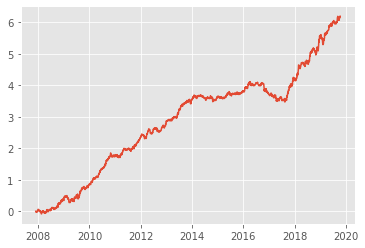

[4e-07, 2e-05, 6.190114056977967, 0.002374420428453382, 6.190114056977967, 0.002374420428453382]


In [42]:
optimize(['TLS.AX','SKC.AX','asx'],[4e-07],[2e-05],True)

In [67]:
toTrade = 'TLS.AX'
index = 'SNP200'
data = pickle.load(open('D:/PRISMO/historicalData/data/asx200nobiasFINAL.pickle','rb'))

data_close = data.loc[(slice(None),[ toTrade])].xs('CLOSE',axis=1,level=1).dropna()


#since the short ratios are stable from around 2011 onwards, we'll only test this period forward

from pandas_datareader import data
tickers = ['^AXJO']

# We would like all available data from 01/01/2000 until 12/31/2016.

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(tickers, 'yahoo')

data_close['SNP200'] = panel_data.Close

In [68]:
data_close[[toTrade+'_diff1','SNP200_diff1']]= data_close.diff()

In [69]:
lags = 5
for lag in range(1,lags+1):
    data_close[toTrade+'_diff1_shift'+str(lag)] = data_close[toTrade+'_diff1'].shift(lag)
    data_close[index +'_diff1_shift'+str(lag)] = data_close[index +'_diff1'].shift(lag)
    data_close['returns_future'+str(lag)] = data_close[toTrade].ffill().pct_change(lag).shift(-lag)


In [70]:
pct = pickle.load(open('D:/PRISMO/historicalData/shorted/df_percent.pickle','rb'))

In [89]:
data_close['pctShort']=pct[toTrade[:-3]]
data_close = data_close.dropna()

In [90]:
data_close.shape

(1127, 20)

In [91]:
W= data_close[[x for x in data_close if x not in [toTrade, index] and 'future' not in x]].dropna()

,TLS.AX_diff1,SNP200_diff1,TLS.AX_diff1_shift1,SNP200_diff1_shift1,TLS.AX_diff1_shift2,SNP200_diff1_shift2,TLS.AX_diff1_shift3,SNP200_diff1_shift3,TLS.AX_diff1_shift4,SNP200_diff1_shift4,TLS.AX_diff1_shift5,SNP200_diff1_shift5,pctShort
Date,,,,,,,,,,,,,
2010-05-07,-0.076962,-92.500000,-0.048102,-100.799805,-0.009620,-63.100098,-0.038481,-48.399902,0.000000,-21.899902,0.019241,21.799805,0.46
2010-05-10,0.048102,119.099609,-0.076962,-92.500000,-0.048102,-100.799805,-0.009620,-63.100098,-0.038481,-48.399902,0.000000,-21.899902,0.13
2010-05-11,-0.019241,-51.799805,0.048102,119.099609,-0.076962,-92.500000,-0.048102,-100.799805,-0.009620,-63.100098,-0.038481,-48.399902,0.08
2010-06-07,-0.057722,-123.500000,0.009620,-36.600098,0.048102,105.000000,0.086583,-32.100098,0.009620,-16.600098,-0.009620,-27.799805,0.47
2010-06-08,0.067342,55.300293,-0.057722,-123.500000,0.009620,-36.600098,0.048102,105.000000,0.086583,-32.100098,0.009620,-16.600098,0.26
2010-06-09,0.038481,4.099609,0.067342,55.300293,-0.057722,-123.500000,0.009620,-36.600098,0.048102,105.000000,0.086583,-32.100098,0.68
2010-06-10,0.028861,50.000000,0.038481,4.099609,0.067342,55.300293,-0.057722,-123.500000,0.009620,-36.600098,0.048102,105.000000,0.09
2010-06-25,-0.038481,-66.700195,0.048102,-6.399902,0.028861,-72.199707,-0.076962,-54.300293,0.105823,60.700195,0.067342,24.600098,0.46
2010-06-28,-0.009620,-28.500000,-0.038481,-66.700195,0.048102,-6.399902,0.028861,-72.199707,-0.076962,-54.300293,0.105823,60.700195,0.45


In [92]:
W = W.values

In [93]:
Y = data_close['returns_future1'].values

In [94]:
Y.shape

(1127,)

In [95]:
W.shape

(1127, 13)

In [23]:
W = data_close[[x for x in data_close if x not in [toTrade, index] and 'future' not in x]]

In [96]:
panel_data.Close

Symbols,^AXJO
Date,
2010-01-03,4876.299805
2010-01-04,4924.299805
2010-01-05,4921.399902
2010-01-06,4899.399902
2010-01-07,4912.100098
2010-01-10,4950.700195
2010-01-11,4899.500000
2010-01-12,4868.100098
2010-01-13,4898.000000


In [117]:
from mpl_toolkits.mplot3d import proj3d
from numpy.linalg import inv
import matplotlib.pyplot as plt
import numpy as np
from numpy import matrix, linalg, ones, array

Q = np.eye(W.shape[0])*.1 # error covariance matrix
#Q[0,0]=1

beta = matrix(ones((W.shape[1],1))) # this is what we are trying estimate
# W = matrix([[1,2],
#             [2,3],
#             [1,1]])

ntrials = 50 
epsilon = np.random.multivariate_normal(tuple([0]*W.shape[0]),Q,ntrials).T 
# y=W*beta+epsilon

# K=inv(W.T*inv(Q)*W)*matrix(W.T)*inv(Q) 
# b=K*y #estimated beta from data

# fig = plt.figure()
# fig.set_size_inches([6,6])

# # some convenience definitions for plotting
# bb = array(b)
# bm = bb.mean(1)
# yy = array(y)
# ax = fig.add_subplot(111, projection='3d')

# ax.plot3D(yy[0,:],yy[1,:],yy[2,:],'mo',label='y',alpha=0.3)
# ax.plot3D([beta[0,0],0],[beta[1,0],0],[0,0],'r-',label=r'$\beta$')
# ax.plot3D([bm[0],0],[bm[1],0],[0,0],'g-',lw=1,label=r'$\hat{\beta}_m$')
# ax.plot3D(bb[0,:],bb[1,:],0*bb[1,:],'.g',alpha=0.5,lw=3,label=r'$\hat{\beta}$')
# ax.legend(loc=0,fontsize=18)
# plt.show()

In [118]:
epsilon.shape

(1127, 50)

In [102]:
beta.shape

(13, 1)

In [107]:
(0,0,0,0,0,0,0,0,0,0,0,0,0)

0